## Common spatial patterns

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import  train_test_split

from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, recall_score, precision_score

import mne
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import read_layout
from mne.decoding import CSP

## set constants

In [2]:
## set params ##
event_id = dict(left=0, right=1) # names of the two classes
SEED = 7

# the task chosen represent open and close left or right fist
tasks = ["03", "07", "11"]

#layout matches the EEG measurement layout
layout = read_layout('EEG1005')

## Utility function

In [68]:
def extract_files (files):
    # read the edf files from disk
    raw_files=[]
    for f in files:
        raw_files.append(read_raw_edf(f, preload=True, stim_channel='auto', verbose =False))
    
    print ('extracting EDFs')
    return raw_files


def preprocess (raw_files):
    # Concatenate raw instances
    raw_data = concatenate_raws(raw_files)

    # rename channels 
    raw_data.rename_channels(lambda x: x.strip('.'))
    
    
    print ('setting channels')
    #Pick channels by type and names; The data contains only eeg samples
    picks = pick_types(raw_data.info, eeg=True)
    
    print('setting filters')
    ## filtering by wave frequency ##
    raw_data.filter(8, 24, fir_design='firwin2', skip_by_annotation='edge', 
                    picks=picks, verbose=False)
    
    print('extracting events')
    ## exctracting events ##
    events = find_events(raw_data, consecutive=True, 
                         stim_channel='STI 014', verbose=False)
    # fix labels 
    events[:, -1] -= 2

    print('extracting epochs')
    ## exctract ephochs ##
    epochs = Epochs(raw_data, events, event_id, -2, 4.1, 
                proj=True, picks=picks,
                baseline=(-2,-.5), 
                preload=True,
                verbose=False)

    #X = epochs.copy().crop(tmin=1., tmax=2.).get_data()
    X = epochs.get_data()
    y = epochs.events[:, -1]

    return(X,y, epochs)


def classify(X, y, clf):

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size=0.1, random_state=SEED, stratify=y)
    
    print('fitting clf')
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    

    print('preparing report')
    print('\n -------------------- \n')
    

    print (classification_report(y_pred, y_test, 
                                     target_names= event_id))

## import data

In [69]:

files = []
files_20 = []
file_1 = []

for i in tasks:    
    task_file_21 = glob.glob('data/S0*1/*R{}.edf'.format(i))
    files_20.append(task_file_21)
    task_file_22 = glob.glob('data/S0*5/*R{}.edf'.format(i))
    files_20.append(task_file_22)
    
    task_file = glob.glob('data/S*/*R{}.edf'.format(i))
    files.append(task_file)
    
    task_file_1 = glob.glob('data/S007/*R{}.edf'.format(i))
    file_1.append(task_file_1)

#flatten lists of files
files = [item for sublist in files for item in sublist]
files_20 = [item for sublist in files_20 for item in sublist]
file_1 = [item for sublist in file_1 for item in sublist]




## results for all of the dataset

files imported
extracting EDFs
setting channels
setting filters
extracting events
extracting epochs
fitting clf
preparing report

 -------------------- 

             precision    recall  f1-score   support

       left       0.67      0.63      0.65       237
      right       0.61      0.65      0.63       212

avg / total       0.64      0.64      0.64       449



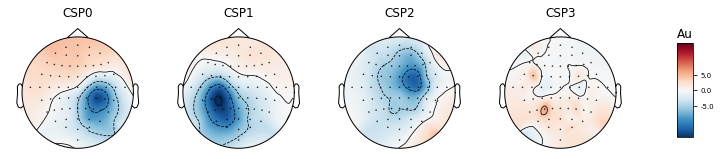

In [70]:
# read the edf files
raw_files=[]
for f in files:
    raw_files.append(read_raw_edf(f, preload=True, stim_channel='auto', 
                                  verbose =False))

print ('files imported')


n_components = 4
csp = CSP(n_components=n_components, reg='oas', log=True, 
          norm_trace=False)
lda = LDA() 
clf = Pipeline([('CSP', csp), ('classification', lda)])


raw_files=extract_files(files)
X,y,epochs = preprocess(raw_files)

classify(X,y,clf)

# Printing the results    
csp.fit_transform(X, y)
# plot CSP patterns estimated on full data for visualization

csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Au', size=1.5)

plt.show()

### results for 20 subjects

extracting EDFs
setting channels
setting filters
extracting events
extracting epochs
fitting clf
preparing report

 -------------------- 

             precision    recall  f1-score   support

       left       0.68      0.73      0.71        41
      right       0.74      0.70      0.72        46

avg / total       0.71      0.71      0.71        87



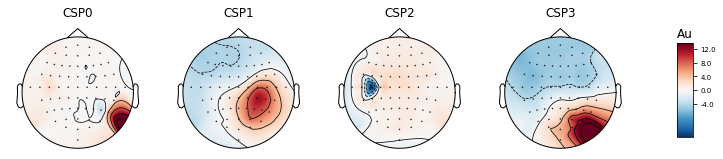

In [71]:
# read the edf files
raw_files_20=[]
for f in files_20:
    raw_files_20.append(read_raw_edf(f, preload=True, stim_channel='auto', 
                                  verbose =False))

n_components = 4
csp = CSP(n_components=n_components, reg='oas', log=True, 
          norm_trace=False)
lda = LDA() 
clf = Pipeline([('CSP', csp), ('classification', lda)])


raw_files_20=extract_files(files_20)
X,y,epochs = preprocess(raw_files_20)

classify(X,y,clf)

# Printing the results    
csp.fit_transform(X, y)
# plot CSP patterns estimated on full data for visualization

csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Au', size=1.5)

plt.show()

## results for 1 subject

In [72]:
#The patterns explain how the measured data was generated from the neural sources (a.k.a. the forward model).

extracting EDFs
setting channels
setting filters
extracting events
extracting epochs
fitting clf
preparing report

 -------------------- 

             precision    recall  f1-score   support

       left       1.00      1.00      1.00         3
      right       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00         5



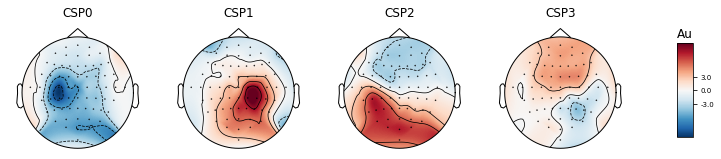

In [73]:
# read the edf files
raw_file_1=[]
for f in file_1:
    raw_file_1.append(read_raw_edf(f, preload=True, stim_channel='auto', 
                                  verbose =False))

n_components = 4
csp = CSP(n_components=n_components, reg='oas', log=True, 
          norm_trace=False)

lda = LDA() 
clf = Pipeline([('CSP', csp), ('classification', lda)])


raw_file_1=extract_files(file_1)
X,y,epochs = preprocess(raw_file_1)

classify(X,y,clf)

# Printing the results    
csp.fit_transform(X, y)
# plot CSP patterns estimated on full data for visualization

csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Au', size=1.5)

plt.show()